In [1]:
!pip install torch torchvision matplotlib seaborn scikit-learn kaggle

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Kaggle API setup for dataset download
!mkdir -p ~/.kaggle
!echo '{"username":"maheralqarra","key":"4552955eece9b6be27da4db74b1430f1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset -p ./data

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset
License(s): CC-BY-SA-4.0
100% 3.18G/3.19G [00:38<00:00, 89.2MB/s]
100% 3.19G/3.19G [00:38<00:00, 89.5MB/s]


In [5]:
# Unzip the downloaded file
import zipfile
with zipfile.ZipFile('./data/v2-plant-seedlings-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [6]:
# Organize the dataset structure
import shutil

dataset_path = './data/plant-seedlings-dataset'
os.makedirs(dataset_path, exist_ok=True)

for folder in os.listdir('./data'):
    folder_path = os.path.join('./data', folder)
    if os.path.isdir(folder_path) and folder not in ['plant-seedlings-dataset']:
        shutil.move(folder_path, dataset_path)

In [7]:
# Remove the "nonsegmentedv2" class
def remove_unwanted_class(dataset_path, unwanted_class):
    folder_to_remove = os.path.join(dataset_path, unwanted_class)
    if os.path.exists(folder_to_remove):
        shutil.rmtree(folder_to_remove)

remove_unwanted_class(dataset_path, 'nonsegmentedv2')

In [8]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [9]:
# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

Random Sample Images from Dataset:


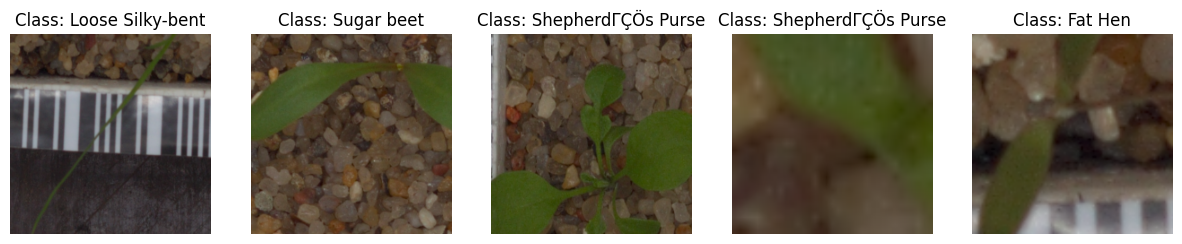

In [10]:
# Function to show random images from the dataset
def show_random_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis('off')
    plt.show()

print("Random Sample Images from Dataset:")
show_random_images(dataset)

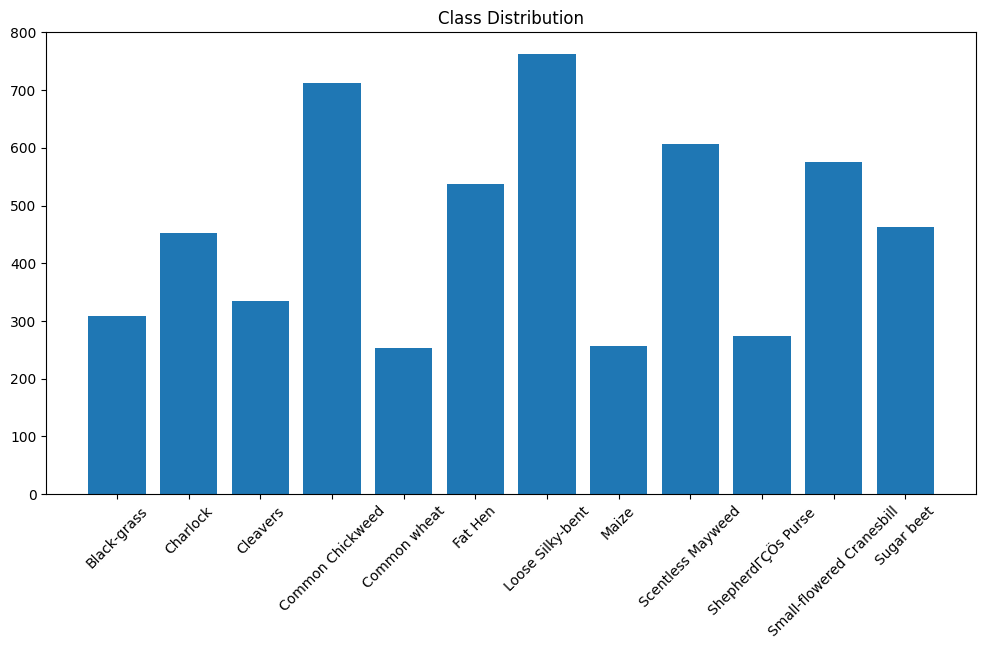

In [11]:
# Visualize class distribution
from collections import Counter
def visualize_class_distribution(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    class_names = [dataset.classes[i] for i in class_counts.keys()]
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, class_counts.values())
    plt.xticks(rotation=45)
    plt.title('Class Distribution')
    plt.show()

visualize_class_distribution(dataset)

In [12]:
# Split Dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# Load Pre-trained ResNet18 Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [15]:
# Training Function
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_accuracy = validate_model(model, val_loader)
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

    plot_metrics(train_losses, val_losses, val_accuracies)

In [16]:
# validation Function
def validate_model(model, val_loader):
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    return val_loss / len(val_loader), val_accuracy

Epoch 1/10, Loss: 1.0271, Val Acc: 84.37%
Epoch 2/10, Loss: 0.4246, Val Acc: 87.26%
Epoch 3/10, Loss: 0.3512, Val Acc: 89.34%
Epoch 4/10, Loss: 0.3034, Val Acc: 89.16%
Epoch 5/10, Loss: 0.2930, Val Acc: 90.97%
Epoch 6/10, Loss: 0.2285, Val Acc: 93.86%
Epoch 7/10, Loss: 0.2082, Val Acc: 92.14%
Epoch 8/10, Loss: 0.2009, Val Acc: 92.05%
Epoch 9/10, Loss: 0.1802, Val Acc: 92.95%
Epoch 10/10, Loss: 0.1739, Val Acc: 93.04%


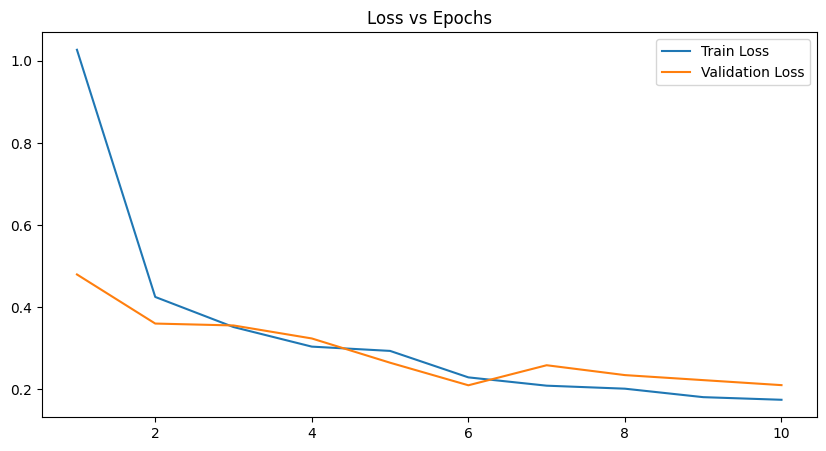

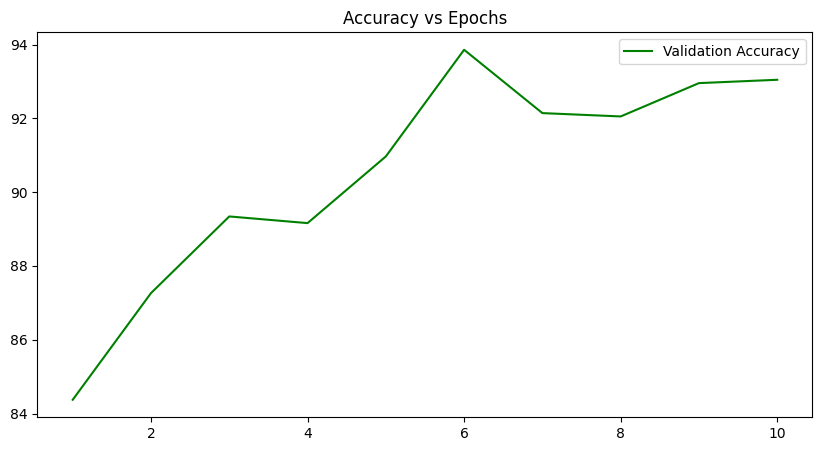

In [17]:
# Plot metrics Function
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.show()

train_model(model, train_loader, val_loader)

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.58      0.48      0.52        23
                 Charlock       1.00      0.92      0.96        48
                 Cleavers       1.00      0.97      0.99        35
         Common Chickweed       0.99      0.96      0.97        75
             Common wheat       0.96      0.96      0.96        27
                  Fat Hen       0.94      0.93      0.93        54
         Loose Silky-bent       0.83      0.90      0.86        77
                    Maize       1.00      1.00      1.00        21
        Scentless Mayweed       0.89      0.97      0.93        70
       ShepherdΓÇÖs Purse       1.00      0.86      0.92        28
Small-flowered Cranesbill       0.98      1.00      0.99        53
               Sugar beet       0.87      0.93      0.90        44

                 accuracy                           0.92       555
                macro avg       0.92 

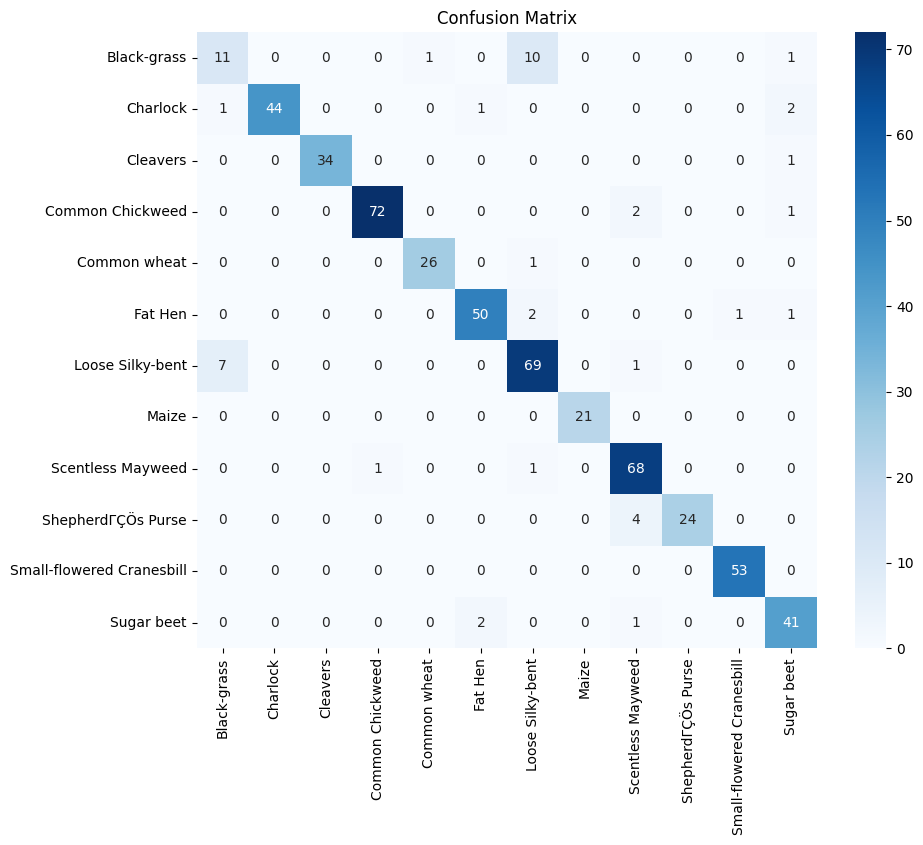

In [18]:
# Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)

In [20]:
# Show image Function
import matplotlib.pyplot as plt

def show_images(images, num_images=5, correct=True):
    """
    Display a list of images with their predicted labels.
    If correct is False, display the true and predicted labels.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        if i >= len(images):
            break

        if correct:
            image, predicted = images[i]
            label_text = f"Predicted: {dataset.classes[predicted]}"
        else:
            image, predicted, true_label = images[i]
            label_text = (f"Predicted: {dataset.classes[predicted]}\n"
                          f"True: {dataset.classes[true_label]}")

        # Display the image
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(label_text, fontsize=12, color='white', backgroundcolor='black')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



Correct Predictions:


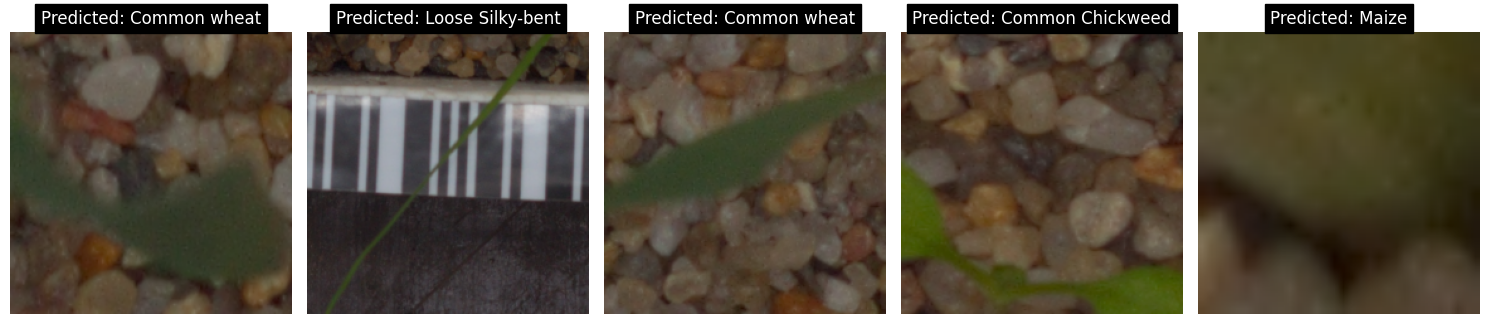


Incorrect Predictions:


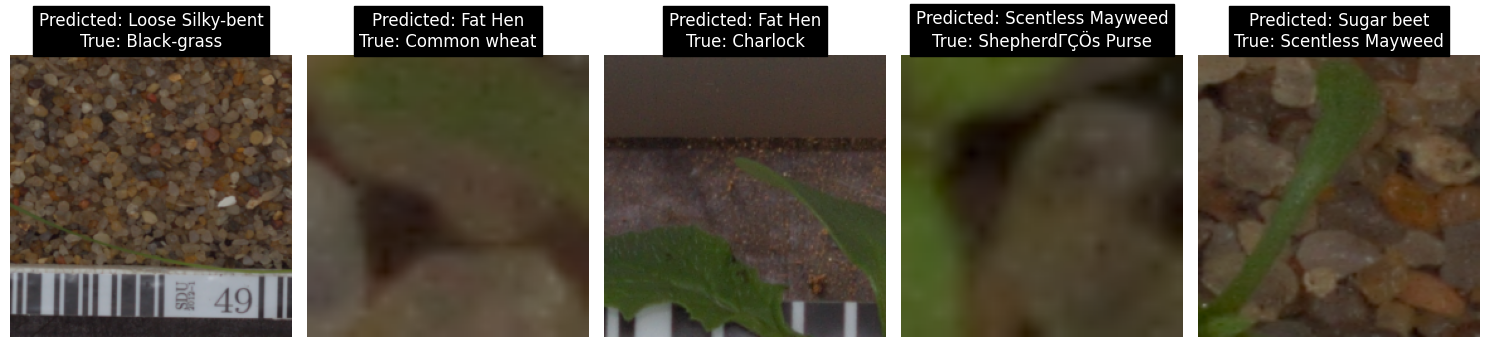

In [21]:
def show_predictions(model, data_loader, num_images=5):
    model.eval()
    correct_images, incorrect_images = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] == labels[i]:
                    correct_images.append((images[i].cpu(), predicted[i]))
                else:
                    incorrect_images.append((images[i].cpu(), predicted[i], labels[i]))

    print("\nCorrect Predictions:")
    show_images(correct_images, num_images, correct=True)
    print("\nIncorrect Predictions:")
    show_images(incorrect_images, num_images, correct=False)

# Run the visualization
show_predictions(model, test_loader)


In [22]:
print("----------------------------------------------------------------------------")

----------------------------------------------------------------------------
